# CCC Python Implementation Profiling

This notebook provides quantitative profiling evidence showing what percentage of CCC (Clustermatch Correlation Coefficient) runtime is attributable to ARI (Adjusted Rand Index) calculations.

**Goal**: Address reviewer feedback requesting profiling data to support the claim that ARI computation represents the main computational bottleneck in CCC.

## Setup

In [7]:
import sys
import os
import cProfile
import pstats
import io
from pstats import SortKey

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set up modern styling
sns.set_theme(style="whitegrid", font_scale=1.1)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.edgecolor'] = '#CCCCCC'
plt.rcParams['grid.color'] = '#EEEEEE'
plt.rcParams['grid.linewidth'] = 0.8

# Add the libs directory to the path
sys.path.insert(0, os.path.abspath('../../libs'))

from ccc.coef.impl import ccc
from ccc.sklearn.metrics import adjusted_rand_index, get_pair_confusion_matrix, get_contingency_matrix

# Set random seed for reproducibility
np.random.seed(42)

print("Setup complete.")

Setup complete.


## Helper Functions

In [8]:
def generate_synthetic_data(n_features: int, n_samples: int, seed: int = 42) -> np.ndarray:
    """Generate synthetic numerical data for benchmarking."""
    np.random.seed(seed)
    return np.random.rand(n_features, n_samples)


def profile_ccc(data: np.ndarray, n_jobs: int = 1) -> pstats.Stats:
    """Profile the CCC function and return stats."""
    profiler = cProfile.Profile()
    profiler.enable()
    result = ccc(data, n_jobs=n_jobs)
    profiler.disable()
    stats = pstats.Stats(profiler)
    return stats, result


# Function category definitions
FUNCTION_CATEGORIES = {
    # ARI Computation (the main bottleneck)
    'adjusted_rand_index': 'ARI',
    'get_pair_confusion_matrix': 'ARI',
    'get_contingency_matrix': 'ARI',
    # Partitioning
    'get_parts': 'Partitioning',
    'run_quantile_clustering': 'Partitioning',
    'get_feature_parts': 'Partitioning',
    'get_range_n_clusters': 'Partitioning',
    'get_perc_from_k': 'Partitioning',
    # Ranking
    'rank': 'Ranking',
    # Coordination/Orchestration
    'cdist_parts_basic': 'Coordination',
    'compute_ccc': 'Coordination',
    'compute_coef': 'Coordination',
    'ccc': 'Coordination',
    'get_chunks': 'Coordination',
    'get_coords_from_index': 'Coordination',
    'get_feature_type_and_encode': 'Coordination',
}

# Modern color palette - vibrant and accessible
CATEGORY_COLORS = {
    'ARI': '#E63946',           # Vibrant red
    'Partitioning': '#457B9D',   # Steel blue
    'Ranking': '#8338EC',        # Purple
    'Coordination': '#06D6A0',   # Mint green
    'NumPy/Numba': '#FF9F1C',    # Orange
    'Other CCC': '#118AB2',      # Ocean blue
    'Other': '#ADB5BD',          # Gray
}

# Category order for consistent visualization
CATEGORY_ORDER = ['ARI', 'Coordination', 'Partitioning', 'NumPy/Numba', 'Ranking', 'Other CCC', 'Other']


def categorize_function(func_name: str, filename: str) -> str:
    """Categorize a function based on its name and source file."""
    if func_name in FUNCTION_CATEGORIES:
        return FUNCTION_CATEGORIES[func_name]
    
    numpy_funcs = ['searchsorted', 'argsort', 'zeros', 'unique', 'full', 
                   'ravel', 'dot', 'sum', 'max', 'argmax', 'floor', 'sqrt',
                   'ceil', 'round', 'array', 'arange', 'empty', 'copy']
    if func_name in numpy_funcs or 'numpy' in filename.lower() or 'numba' in filename.lower():
        return 'NumPy/Numba'
    
    if 'ccc' in filename.lower():
        return 'Other CCC'
    
    return 'Other'


def extract_all_function_times(stats: pstats.Stats, top_n: int = 20, 
                                min_pct: float = 0.1) -> tuple:
    """Extract comprehensive timing information for ALL functions."""
    stats_dict = stats.stats
    
    total_time = 0
    for key, value in stats_dict.items():
        filename, line_num, func_name = key
        if func_name == 'ccc' and 'impl.py' in filename:
            total_time = value[3]
            break
    
    if total_time == 0:
        total_time = max(v[3] for v in stats_dict.values())
    
    func_data = []
    for key, value in stats_dict.items():
        filename, line_num, func_name = key
        ncalls, tottime, cumtime = value[0], value[2], value[3]
        
        pct = (tottime / total_time) * 100 if total_time > 0 else 0
        
        if pct < min_pct:
            continue
        
        category = categorize_function(func_name, filename)
        short_file = filename.split('/')[-1] if '/' in filename else filename
        
        func_data.append({
            'Function': func_name,
            'File': short_file,
            'Category': category,
            'Calls': ncalls,
            'TotTime': tottime,
            'CumTime': cumtime,
            'TotTime%': pct,
            'CumTime%': (cumtime / total_time) * 100 if total_time > 0 else 0
        })
    
    df = pd.DataFrame(func_data)
    df = df.sort_values('TotTime', ascending=False).head(top_n)
    df = df.reset_index(drop=True)
    
    return df, total_time


def extract_function_times(stats: pstats.Stats) -> dict:
    """Extract timing information for key functions from profiling stats."""
    stats_dict = stats.stats
    
    ari_functions = ['adjusted_rand_index', 'get_pair_confusion_matrix', 'get_contingency_matrix']
    partitioning_functions = ['get_parts', 'run_quantile_clustering', 'get_feature_parts']
    other_functions = ['cdist_parts_basic', 'compute_ccc', 'compute_coef', 'ccc']
    
    results = {'ari': {}, 'partitioning': {}, 'other': {}, 'total_time': 0.0}
    
    for key, value in stats_dict.items():
        filename, line_num, func_name = key
        ncalls, tottime, cumtime = value[0], value[2], value[3]
        
        if func_name in ari_functions:
            results['ari'][func_name] = {'ncalls': ncalls, 'tottime': tottime, 'cumtime': cumtime}
        elif func_name in partitioning_functions:
            results['partitioning'][func_name] = {'ncalls': ncalls, 'tottime': tottime, 'cumtime': cumtime}
        elif func_name in other_functions:
            results['other'][func_name] = {'ncalls': ncalls, 'tottime': tottime, 'cumtime': cumtime}
        
        if func_name == 'ccc' and 'impl.py' in filename:
            results['total_time'] = cumtime
    
    return results


def calculate_percentages(results: dict) -> dict:
    """Calculate percentage of total time for each category."""
    total = results['total_time']
    if total == 0:
        return {'ari_pct': 0, 'partitioning_pct': 0, 'other_pct': 0}
    
    ari_time = sum(v['tottime'] for v in results['ari'].values())
    part_time = sum(v['tottime'] for v in results['partitioning'].values())
    
    return {
        'ari_time': ari_time,
        'ari_pct': (ari_time / total) * 100,
        'partitioning_time': part_time,
        'partitioning_pct': (part_time / total) * 100,
        'other_time': total - ari_time - part_time,
        'other_pct': ((total - ari_time - part_time) / total) * 100,
        'total_time': total
    }


def calculate_category_totals(func_df: pd.DataFrame, total_time: float) -> pd.DataFrame:
    """Calculate total time spent in each category."""
    category_totals = func_df.groupby('Category').agg({
        'TotTime': 'sum',
        'Calls': 'sum'
    }).reset_index()
    
    category_totals['Percentage'] = (category_totals['TotTime'] / total_time) * 100
    category_totals = category_totals.sort_values('TotTime', ascending=False)
    
    return category_totals

## Profiling Across Different Workload Sizes

We test with three representative workload sizes:
- **Small**: 10 features x 100 samples (45 pairwise comparisons)
- **Medium**: 50 features x 500 samples (1,225 pairwise comparisons)
- **Large**: 100 features x 1000 samples (4,950 pairwise comparisons)

In [ ]:
# Define workload sizes
workloads = [
    {'name': 'Small', 'n_features': 500, 'n_samples': 500},
    {'name': 'Medium', 'n_features': 2500, 'n_samples': 500},
    {'name': 'Large', 'n_features': 5000, 'n_samples': 500},
]

# Store results for each workload
all_results = []
all_func_dfs = []  # Store comprehensive function breakdowns

for workload in workloads:
    print(f"\nProfiling {workload['name']} workload: {workload['n_features']} features x {workload['n_samples']} samples...")
    
    # Generate data
    data = generate_synthetic_data(workload['n_features'], workload['n_samples'])
    n_pairs = (workload['n_features'] * (workload['n_features'] - 1)) // 2
    print(f"  Number of pairwise comparisons: {n_pairs}")
    
    # Profile (using single thread to get clean profiling data)
    stats, ccc_result = profile_ccc(data, n_jobs=1)
    
    # Extract comprehensive function times
    func_df, total_time = extract_all_function_times(stats, top_n=25, min_pct=0.05)
    all_func_dfs.append((workload['name'], func_df, total_time))
    
    # Extract category-based results (for backward compatibility)
    func_times = extract_function_times(stats)
    percentages = calculate_percentages(func_times)
    
    # Store results
    result = {
        'workload': workload['name'],
        'n_features': workload['n_features'],
        'n_samples': workload['n_samples'],
        'n_pairs': n_pairs,
        **percentages,
        'func_times': func_times
    }
    all_results.append(result)
    
    print(f"  Total time: {percentages['total_time']:.4f}s")
    print(f"  ARI time: {percentages['ari_time']:.4f}s ({percentages['ari_pct']:.1f}%)")
    print(f"  Partitioning time: {percentages['partitioning_time']:.4f}s ({percentages['partitioning_pct']:.1f}%)")

print("\nProfiling complete.")


Profiling Small workload: 500 features x 500 samples...
  Number of pairwise comparisons: 124750
  Total time: 45.4448s
  ARI time: 33.0788s (72.8%)
  Partitioning time: 0.0983s (0.2%)

Profiling Medium workload: 2500 features x 500 samples...
  Number of pairwise comparisons: 3123750
  Total time: 1132.8582s
  ARI time: 830.8326s (73.3%)
  Partitioning time: 0.4807s (0.0%)

Profiling Large workload: 5000 features x 500 samples...
  Number of pairwise comparisons: 12497500
  Total time: 4527.3556s
  ARI time: 3328.4035s (73.5%)
  Partitioning time: 0.9603s (0.0%)

Profiling complete.


## Results Summary Table

In [10]:
# Create summary DataFrame
summary_data = []
for r in all_results:
    summary_data.append({
        'Workload': r['workload'],
        'Features': r['n_features'],
        'Samples': r['n_samples'],
        'Pairwise Comparisons': r['n_pairs'],
        'Total Time (s)': f"{r['total_time']:.4f}",
        'ARI Time (s)': f"{r['ari_time']:.4f}",
        'ARI %': f"{r['ari_pct']:.1f}%",
        'Partitioning %': f"{r['partitioning_pct']:.1f}%",
        'Other %': f"{r['other_pct']:.1f}%"
    })

summary_df = pd.DataFrame(summary_data)
print("Runtime Breakdown by Workload Size")
print("=" * 80)
display(summary_df)

Runtime Breakdown by Workload Size


,Workload,Features,Samples,Pairwise Comparisons,Total Time (s),ARI Time (s),ARI %,Partitioning %,Other %
0,Small,500,500,124750,45.4448,33.0788,72.8%,0.2%,27.0%
1,Medium,2500,500,3123750,1132.8582,830.8326,73.3%,0.0%,26.6%
2,Large,5000,500,12497500,4527.3556,3328.4035,73.5%,0.0%,26.5%


## Detailed Function-Level Breakdown

Show the number of calls and time spent in each ARI-related function.

In [11]:
# Show detailed ARI function breakdown for each workload
for r in all_results:
    print(f"\n{r['workload']} Workload - ARI Function Breakdown:")
    print("-" * 60)
    
    ari_data = []
    for func_name, timing in r['func_times']['ari'].items():
        ari_data.append({
            'Function': func_name,
            'Calls': timing['ncalls'],
            'Total Time (s)': f"{timing['tottime']:.6f}",
            'Cumulative Time (s)': f"{timing['cumtime']:.6f}"
        })
    
    if ari_data:
        ari_df = pd.DataFrame(ari_data)
        display(ari_df)
    else:
        print("  No ARI function data captured.")


Small Workload - ARI Function Breakdown:
------------------------------------------------------------


,Function,Calls,Total Time (s),Cumulative Time (s)
0,get_pair_confusion_matrix,10104750,13.860580,14.924982
1,adjusted_rand_index,10104750,19.218175,34.143157



Medium Workload - ARI Function Breakdown:
------------------------------------------------------------


,Function,Calls,Total Time (s),Cumulative Time (s)
0,get_pair_confusion_matrix,253023750,349.931698,376.683189
1,adjusted_rand_index,253023750,480.900921,857.584109



Large Workload - ARI Function Breakdown:
------------------------------------------------------------


,Function,Calls,Total Time (s),Cumulative Time (s)
0,get_pair_confusion_matrix,1012297500,1397.422601,1506.873811
1,adjusted_rand_index,1012297500,1930.980864,3437.854676


## Comprehensive Function-Level Breakdown

This section shows the complete runtime breakdown across ALL functions, not just ARI-related ones. Functions are color-coded by category:
- **ARI** (Red): Adjusted Rand Index computation
- **Partitioning** (Blue): Data partitioning and clustering
- **Ranking** (Purple): Rank computation
- **Coordination** (Green): Orchestration and control flow
- **NumPy/Numba** (Orange): Low-level array operations
- **Other** (Gray): Miscellaneous functions

In [12]:
# Display comprehensive function breakdown for each workload
for workload_name, func_df, total_time in all_func_dfs:
    print(f"\n{'='*80}")
    print(f"{workload_name} Workload - Top Functions by Runtime (Total: {total_time:.4f}s)")
    print(f"{'='*80}")
    
    # Format the DataFrame for display
    display_df = func_df.copy()
    display_df['TotTime'] = display_df['TotTime'].apply(lambda x: f"{x:.6f}")
    display_df['CumTime'] = display_df['CumTime'].apply(lambda x: f"{x:.6f}")
    display_df['TotTime%'] = display_df['TotTime%'].apply(lambda x: f"{x:.2f}%")
    display_df['CumTime%'] = display_df['CumTime%'].apply(lambda x: f"{x:.2f}%")
    
    display(display_df[['Function', 'Category', 'Calls', 'TotTime', 'TotTime%', 'CumTime', 'CumTime%']])


Small Workload - Top Functions by Runtime (Total: 45.4448s)


,Function,Category,Calls,TotTime,TotTime%,CumTime,CumTime%
0,adjusted_rand_index,ARI,10104750,19.218175,42.29%,34.143157,75.13%
1,get_pair_confusion_matrix,ARI,10104750,13.860580,30.50%,14.924982,32.84%
2,cdist_parts_basic,Coordination,124750,10.638811,23.41%,44.799360,98.58%
3,_numba_unpickle,NumPy/Numba,10109251,1.064979,2.34%,1.064979,2.34%
4,compute_coef,Coordination,1,0.319046,0.70%,45.338647,99.77%
5,compute_ccc,Coordination,124750,0.126150,0.28%,45.001017,99.02%
6,get_parts,Partitioning,4500,0.091494,0.20%,0.092070,0.20%
7,<method 'argmax' of 'numpy.ndarray' objects>,Other,124750,0.032880,0.07%,0.032880,0.07%
8,unravel_index_2d,Other CCC,124750,0.029312,0.06%,0.029312,0.06%



Medium Workload - Top Functions by Runtime (Total: 1132.8582s)


,Function,Category,Calls,TotTime,TotTime%,CumTime,CumTime%
0,adjusted_rand_index,ARI,253023750,480.900921,42.45%,857.584109,75.70%
1,get_pair_confusion_matrix,ARI,253023750,349.931698,30.89%,376.683189,33.25%
2,cdist_parts_basic,Coordination,3123750,261.412209,23.08%,1119.389797,98.81%
3,_numba_unpickle,NumPy/Numba,253046251,26.754183,2.36%,26.754183,2.36%
4,compute_coef,Coordination,1,7.623277,0.67%,1132.307349,99.95%
5,compute_ccc,Coordination,3123750,3.035858,0.27%,1124.238922,99.24%
6,<method 'argmax' of 'numpy.ndarray' objects>,Other,3123750,0.766228,0.07%,0.766228,0.07%
7,unravel_index_2d,Other CCC,3123750,0.719777,0.06%,0.719777,0.06%



Large Workload - Top Functions by Runtime (Total: 4527.3556s)


,Function,Category,Calls,TotTime,TotTime%,CumTime,CumTime%
0,adjusted_rand_index,ARI,1012297500,1930.980864,42.65%,3437.854676,75.94%
1,get_pair_confusion_matrix,ARI,1012297500,1397.422601,30.87%,1506.873811,33.28%
2,cdist_parts_basic,Coordination,12497500,1035.790181,22.88%,4475.245352,98.85%
3,_numba_unpickle,NumPy/Numba,1012342501,109.456646,2.42%,109.456646,2.42%
4,compute_coef,Coordination,1,29.864304,0.66%,4526.169097,99.97%
5,compute_ccc,Coordination,12497500,12.240126,0.27%,4494.614490,99.28%
6,<method 'argmax' of 'numpy.ndarray' objects>,Other,12497500,2.997781,0.07%,2.997781,0.07%
7,unravel_index_2d,Other CCC,12497500,2.839417,0.06%,2.839417,0.06%


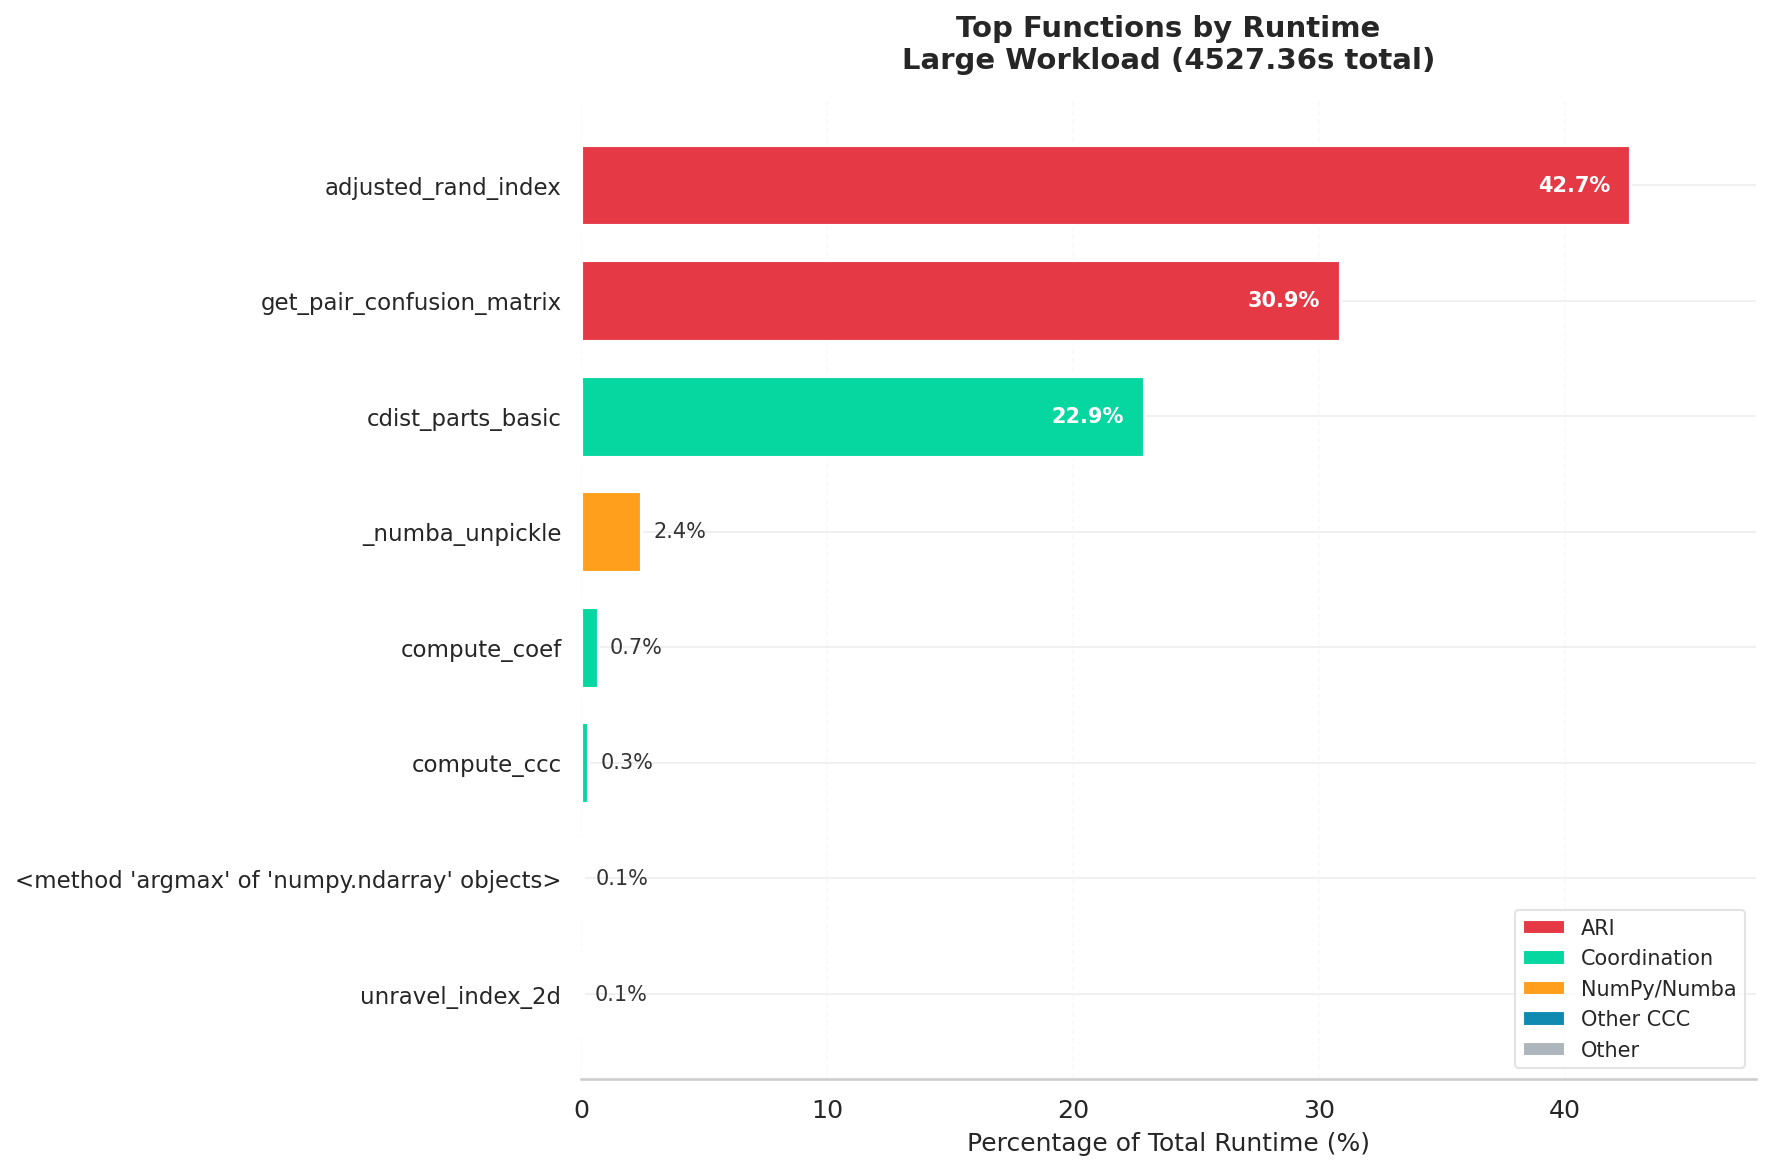

Figure saved as 'ccc_function_breakdown_bar.png'


In [13]:
# Modern horizontal bar chart showing top functions by runtime
workload_name, func_df, total_time = all_func_dfs[-1]  # Large workload

fig, ax = plt.subplots(figsize=(12, 8))

# Prepare data - take top 12 functions for cleaner visualization
plot_df = func_df.head(12).copy()
plot_df = plot_df.iloc[::-1]  # Reverse for horizontal bar chart (highest at top)

# Create bars with category colors and rounded edges
colors = [CATEGORY_COLORS.get(cat, '#ADB5BD') for cat in plot_df['Category']]
bars = ax.barh(range(len(plot_df)), plot_df['TotTime%'], color=colors, 
               height=0.7, edgecolor='white', linewidth=1.5)

# Add function names on y-axis with better formatting
ax.set_yticks(range(len(plot_df)))
ax.set_yticklabels([f"{row['Function']}" for _, row in plot_df.iterrows()], 
                   fontsize=11, fontweight='medium')

# Add percentage labels on bars with better positioning
for i, (idx, row) in enumerate(plot_df.iterrows()):
    # Place label inside bar if bar is wide enough, otherwise outside
    if row['TotTime%'] > 5:
        ax.text(row['TotTime%'] - 0.8, i, f"{row['TotTime%']:.1f}%", 
                va='center', ha='right', fontsize=10, fontweight='bold', color='white')
    else:
        ax.text(row['TotTime%'] + 0.5, i, f"{row['TotTime%']:.1f}%", 
                va='center', ha='left', fontsize=10, fontweight='medium', color='#333333')

# Customize appearance
ax.set_xlabel('Percentage of Total Runtime (%)', fontsize=12, fontweight='medium')
ax.set_title(f'Top Functions by Runtime\n{workload_name} Workload ({total_time:.2f}s total)', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlim(0, max(plot_df['TotTime%']) * 1.12)

# Remove top and right spines
sns.despine(left=True, bottom=False)
ax.tick_params(left=False)

# Add subtle vertical gridlines
ax.xaxis.grid(True, linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

# Add legend with modern styling
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=CATEGORY_COLORS[cat], label=cat, edgecolor='white', linewidth=1) 
                   for cat in CATEGORY_ORDER if cat in plot_df['Category'].values]
legend = ax.legend(handles=legend_elements, loc='lower right', fontsize=10, 
                   frameon=True, fancybox=True, shadow=False, 
                   edgecolor='#DDDDDD', facecolor='white')

plt.tight_layout()
plt.savefig('ccc_function_breakdown_bar.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("Figure saved as 'ccc_function_breakdown_bar.png'")

In [14]:
# Category totals summary across all workloads
print("Category Breakdown Summary")
print("=" * 80)

for workload_name, func_df, total_time in all_func_dfs:
    print(f"\n{workload_name} Workload (Total: {total_time:.4f}s):")
    print("-" * 50)
    
    cat_totals = calculate_category_totals(func_df, total_time)
    
    for _, row in cat_totals.iterrows():
        print(f"  {row['Category']:15s}: {row['TotTime']:.4f}s ({row['Percentage']:5.1f}%) - {int(row['Calls']):,} calls")

Category Breakdown Summary

Small Workload (Total: 45.4448s):
--------------------------------------------------
  ARI            : 33.0788s ( 72.8%) - 20,209,500 calls
  Coordination   : 11.0840s ( 24.4%) - 249,501 calls
  NumPy/Numba    : 1.0650s (  2.3%) - 10,109,251 calls
  Partitioning   : 0.0915s (  0.2%) - 4,500 calls
  Other          : 0.0329s (  0.1%) - 124,750 calls
  Other CCC      : 0.0293s (  0.1%) - 124,750 calls

Medium Workload (Total: 1132.8582s):
--------------------------------------------------
  ARI            : 830.8326s ( 73.3%) - 506,047,500 calls
  Coordination   : 272.0713s ( 24.0%) - 6,247,501 calls
  NumPy/Numba    : 26.7542s (  2.4%) - 253,046,251 calls
  Other          : 0.7662s (  0.1%) - 3,123,750 calls
  Other CCC      : 0.7198s (  0.1%) - 3,123,750 calls

Large Workload (Total: 4527.3556s):
--------------------------------------------------
  ARI            : 3328.4035s ( 73.5%) - 2,024,595,000 calls
  Coordination   : 1077.8946s ( 23.8%) - 24,995,001 

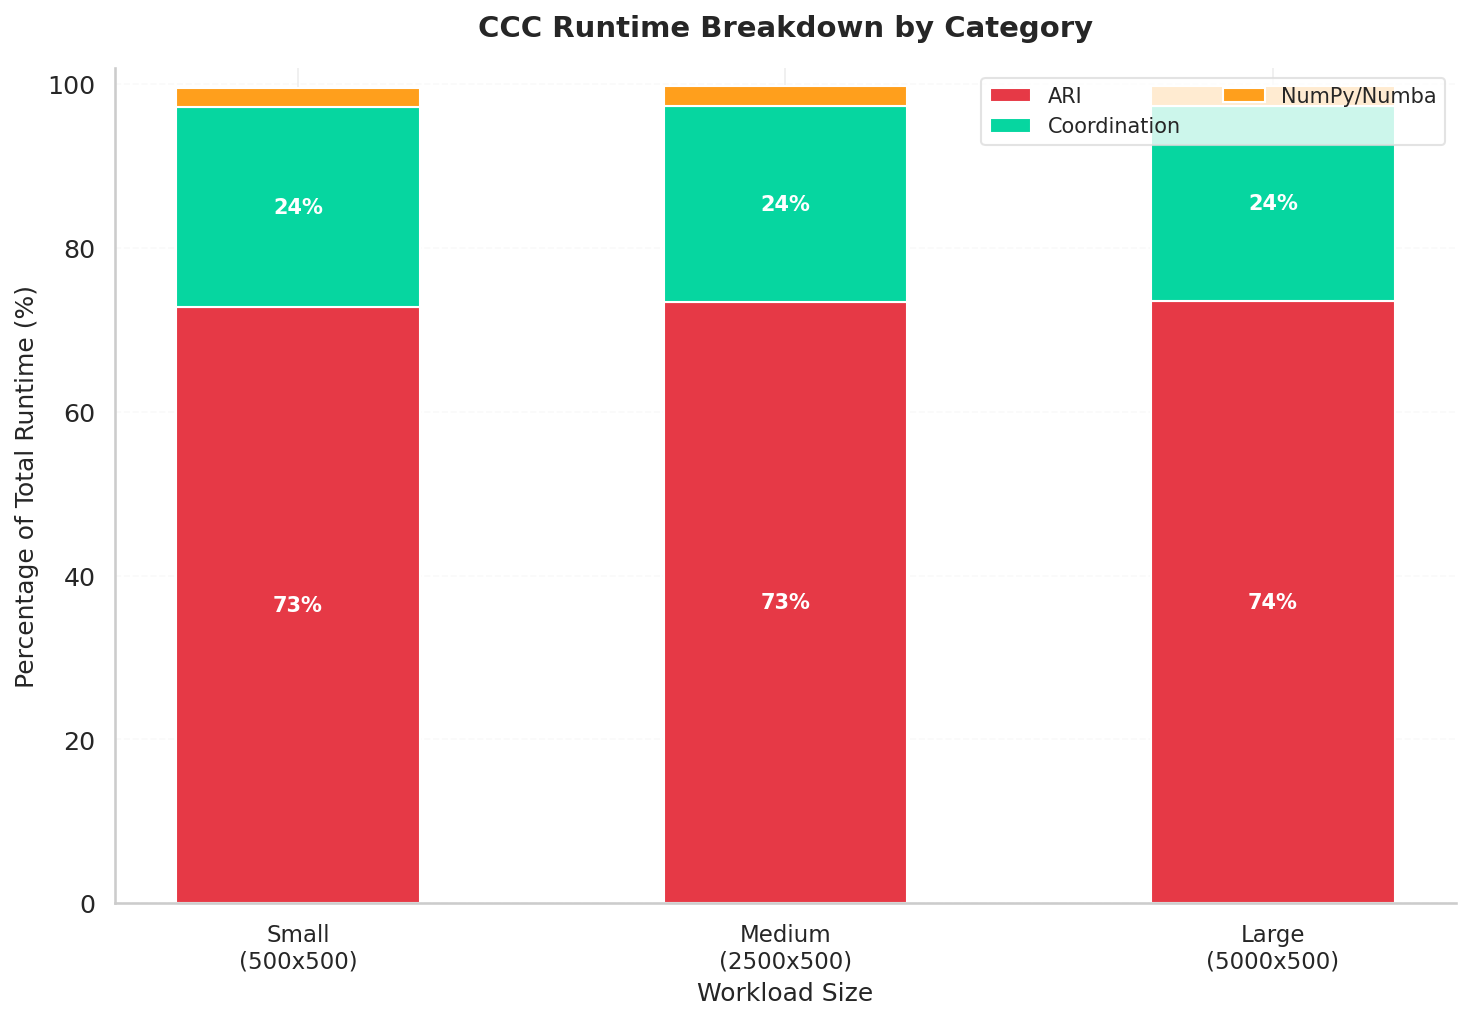

Figure saved as 'ccc_category_breakdown_comparison.png'


In [15]:
# Modern stacked bar chart comparing category breakdown across workloads
fig, ax = plt.subplots(figsize=(10, 7))

# Collect category data for each workload
workload_names = []
category_data = {cat: [] for cat in CATEGORY_ORDER}

for workload_name, func_df, total_time in all_func_dfs:
    workload_names.append(workload_name)
    cat_totals = calculate_category_totals(func_df, total_time)
    
    for cat in CATEGORY_ORDER:
        cat_row = cat_totals[cat_totals['Category'] == cat]
        if len(cat_row) > 0:
            category_data[cat].append(cat_row['Percentage'].values[0])
        else:
            category_data[cat].append(0)

# Create stacked bar chart
x = np.arange(len(workload_names))
width = 0.5
bottom = np.zeros(len(workload_names))

# Only include categories that have significant data
active_categories = [(cat, data) for cat, data in category_data.items() if max(data) > 0.5]

for cat, data in active_categories:
    bars = ax.bar(x, data, width, label=cat, bottom=bottom, 
                  color=CATEGORY_COLORS[cat], edgecolor='white', linewidth=1)
    
    # Add percentage labels for significant segments
    for i, (d, b) in enumerate(zip(data, bottom)):
        if d > 4:  # Only label if > 4%
            ax.text(i, b + d/2, f'{d:.0f}%', ha='center', va='center', 
                   fontsize=10, fontweight='bold', color='white')
    
    bottom += np.array(data)

# Customize appearance
ax.set_ylabel('Percentage of Total Runtime (%)', fontsize=12, fontweight='medium')
ax.set_xlabel('Workload Size', fontsize=12, fontweight='medium')
ax.set_title('CCC Runtime Breakdown by Category', fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels([f"{name}\n({r['n_features']}x{r['n_samples']})" 
                   for name, r in zip(workload_names, all_results)], fontsize=11)
ax.set_ylim(0, 102)

# Remove top and right spines
sns.despine()

# Add subtle horizontal gridlines
ax.yaxis.grid(True, linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

# Modern legend
legend = ax.legend(loc='upper right', fontsize=10, frameon=True, 
                   fancybox=True, shadow=False, edgecolor='#DDDDDD', 
                   facecolor='white', ncol=2)

plt.tight_layout()
plt.savefig('ccc_category_breakdown_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("Figure saved as 'ccc_category_breakdown_comparison.png'")

## Visualizations

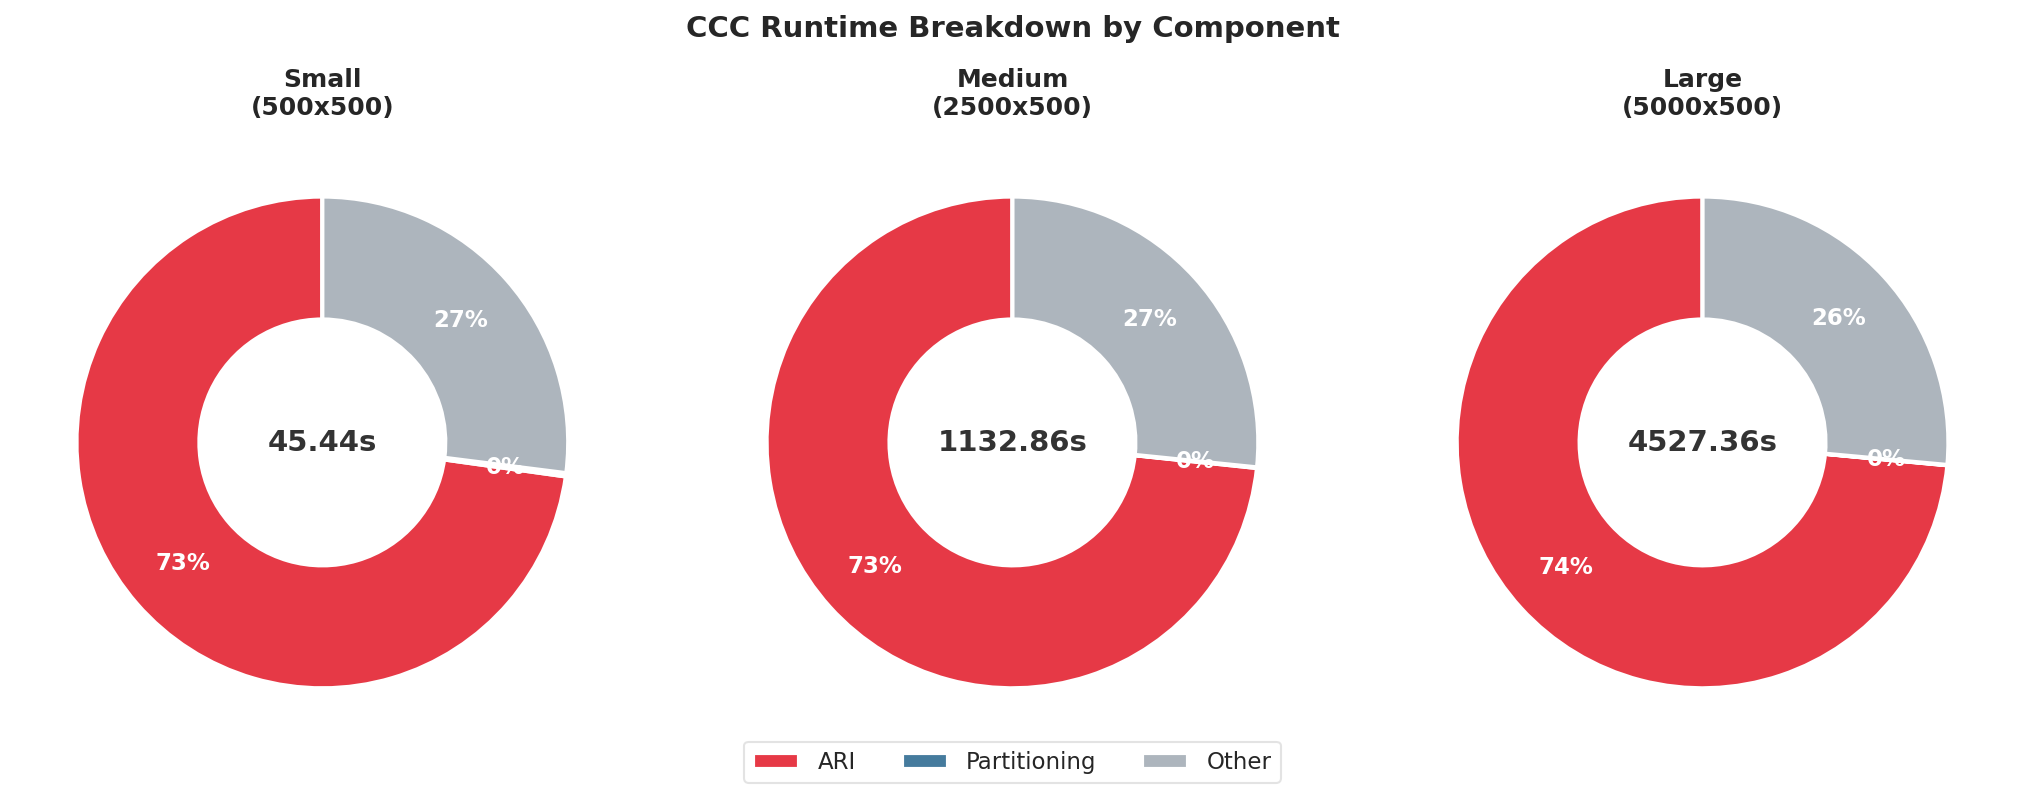

Figure saved as 'ccc_runtime_breakdown_donut.png'


In [16]:
# Modern donut charts showing runtime breakdown
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# Modern colors for simplified categories
donut_colors = {
    'ARI': '#E63946',
    'Partitioning': '#457B9D', 
    'Other': '#ADB5BD'
}

for idx, r in enumerate(all_results):
    ax = axes[idx]
    
    # Data for donut chart
    sizes = [r['ari_pct'], r['partitioning_pct'], r['other_pct']]
    labels = ['ARI', 'Partitioning', 'Other']
    colors = [donut_colors[l] for l in labels]
    
    # Create donut chart
    wedges, texts, autotexts = ax.pie(
        sizes, 
        labels=None,  # We'll add custom labels
        colors=colors,
        autopct='%1.0f%%',
        startangle=90,
        pctdistance=0.75,
        wedgeprops=dict(width=0.5, edgecolor='white', linewidth=2)
    )
    
    # Style the percentage text
    for autotext in autotexts:
        autotext.set_fontsize(11)
        autotext.set_fontweight('bold')
        autotext.set_color('white')
    
    # Add center text with total time
    ax.text(0, 0, f'{r["total_time"]:.2f}s', ha='center', va='center', 
            fontsize=14, fontweight='bold', color='#333333')
    
    # Title
    ax.set_title(f"{r['workload']}\n({r['n_features']}x{r['n_samples']})", 
                 fontsize=12, fontweight='bold', pad=10)

# Add a shared legend at the bottom
fig.legend(wedges, labels, loc='lower center', ncol=3, fontsize=11,
           frameon=True, fancybox=True, edgecolor='#DDDDDD', 
           facecolor='white', bbox_to_anchor=(0.5, -0.02))

plt.suptitle('CCC Runtime Breakdown by Component', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('ccc_runtime_breakdown_donut.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("Figure saved as 'ccc_runtime_breakdown_donut.png'")

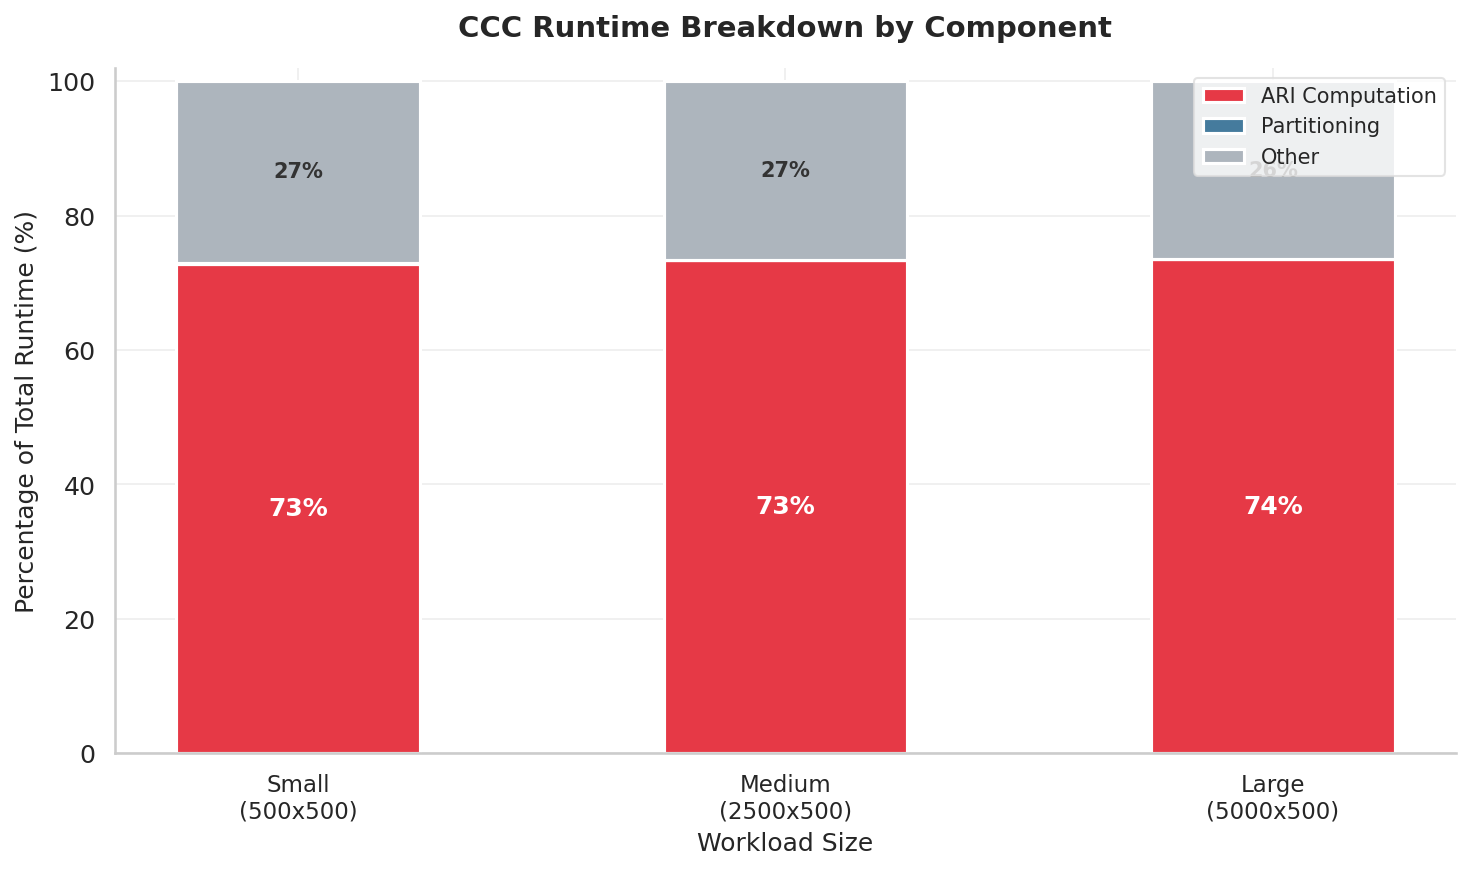

Figure saved as 'ccc_runtime_breakdown_bar.png'


In [17]:
# Modern stacked bar chart showing runtime breakdown
fig, ax = plt.subplots(figsize=(10, 6))

workload_names = [r['workload'] for r in all_results]
ari_pcts = [r['ari_pct'] for r in all_results]
part_pcts = [r['partitioning_pct'] for r in all_results]
other_pcts = [r['other_pct'] for r in all_results]

x = np.arange(len(workload_names))
width = 0.5

# Modern colors
bar_colors = {'ARI': '#E63946', 'Partitioning': '#457B9D', 'Other': '#ADB5BD'}

# Create stacked bars with white edges
bars1 = ax.bar(x, ari_pcts, width, label='ARI Computation', 
               color=bar_colors['ARI'], edgecolor='white', linewidth=1.5)
bars2 = ax.bar(x, part_pcts, width, bottom=ari_pcts, label='Partitioning', 
               color=bar_colors['Partitioning'], edgecolor='white', linewidth=1.5)
bars3 = ax.bar(x, other_pcts, width, bottom=[a+p for a,p in zip(ari_pcts, part_pcts)], 
               label='Other', color=bar_colors['Other'], edgecolor='white', linewidth=1.5)

# Add labels on bars
for i, (a, p, o) in enumerate(zip(ari_pcts, part_pcts, other_pcts)):
    # ARI label (always visible)
    ax.text(i, a/2, f'{a:.0f}%', ha='center', va='center', 
            fontsize=12, fontweight='bold', color='white')
    # Partitioning label (only if > 3%)
    if p > 3:
        ax.text(i, a + p/2, f'{p:.0f}%', ha='center', va='center', 
                fontsize=10, fontweight='bold', color='white')
    # Other label
    ax.text(i, a + p + o/2, f'{o:.0f}%', ha='center', va='center', 
            fontsize=10, fontweight='bold', color='#333333')

# Customize appearance
ax.set_ylabel('Percentage of Total Runtime (%)', fontsize=12, fontweight='medium')
ax.set_xlabel('Workload Size', fontsize=12, fontweight='medium')
ax.set_title('CCC Runtime Breakdown by Component', fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels([f"{r['workload']}\n({r['n_features']}x{r['n_samples']})" 
                   for r in all_results], fontsize=11)
ax.set_ylim(0, 102)

# Remove top and right spines
sns.despine()

# Modern legend
legend = ax.legend(loc='upper right', fontsize=10, frameon=True, 
                   fancybox=True, shadow=False, edgecolor='#DDDDDD', facecolor='white')

plt.tight_layout()
plt.savefig('ccc_runtime_breakdown_bar.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("Figure saved as 'ccc_runtime_breakdown_bar.png'")

## Analysis and Conclusions

In [18]:
# Calculate average ARI percentage across all workloads
avg_ari_pct = np.mean([r['ari_pct'] for r in all_results])
min_ari_pct = min([r['ari_pct'] for r in all_results])
max_ari_pct = max([r['ari_pct'] for r in all_results])

print("="*80)
print("SUMMARY: ARI Computation as CCC Bottleneck")
print("="*80)
print(f"\nAcross the tested workloads:")
print(f"  - Average ARI percentage: {avg_ari_pct:.1f}%")
print(f"  - Range: {min_ari_pct:.1f}% to {max_ari_pct:.1f}%")
print(f"\nThese results demonstrate that ARI computation represents the")
print(f"dominant computational component of the CCC algorithm, consuming")
print(f"approximately {avg_ari_pct:.0f}% of the total runtime.")
print("\n" + "="*80)

SUMMARY: ARI Computation as CCC Bottleneck

Across the tested workloads:
  - Average ARI percentage: 73.2%
  - Range: 72.8% to 73.5%

These results demonstrate that ARI computation represents the
dominant computational component of the CCC algorithm, consuming
approximately 73% of the total runtime.



## Scaling Analysis: Number of ARI Calls

For a dataset with $n$ features and $k$ partitions per feature, CCC performs:
- $\frac{n(n-1)}{2}$ pairwise feature comparisons
- For each comparison: $k^2$ ARI calculations (comparing all partition pairs)

Total ARI calls: $\frac{n(n-1)}{2} \times k^2$

In [19]:
# Show number of ARI calls for each workload
print("Number of ARI Function Calls by Workload:")
print("-" * 50)

for r in all_results:
    ari_calls = r['func_times']['ari'].get('adjusted_rand_index', {}).get('ncalls', 'N/A')
    n_pairs = r['n_pairs']
    
    print(f"\n{r['workload']} ({r['n_features']}x{r['n_samples']}):")
    print(f"  - Pairwise comparisons: {n_pairs}")
    print(f"  - ARI function calls: {ari_calls}")
    if isinstance(ari_calls, int):
        print(f"  - Avg ARI calls per comparison: {ari_calls/n_pairs:.1f}")

Number of ARI Function Calls by Workload:
--------------------------------------------------

Small (500x500):
  - Pairwise comparisons: 124750
  - ARI function calls: 10104750
  - Avg ARI calls per comparison: 81.0

Medium (2500x500):
  - Pairwise comparisons: 3123750
  - ARI function calls: 253023750
  - Avg ARI calls per comparison: 81.0

Large (5000x500):
  - Pairwise comparisons: 12497500
  - ARI function calls: 1012297500
  - Avg ARI calls per comparison: 81.0


---

## Appendix: Full Profiling Output

For reference, here is the complete cProfile output for the large workload.

In [20]:
# Re-run profiling for large workload and show full stats
print("Full cProfile output for Large workload (100x1000):")
print("=" * 80)

data = generate_synthetic_data(100, 1000)
stats, _ = profile_ccc(data, n_jobs=1)

# Print top 20 functions by cumulative time
stats.strip_dirs().sort_stats(SortKey.CUMULATIVE).print_stats(20)

Full cProfile output for Large workload (100x1000):
         1240579 function calls in 1.957 seconds

   Ordered by: cumulative time
   List reduced from 107 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.004    0.004    1.957    1.957 impl.py:587(ccc)
        1    0.012    0.012    1.907    1.907 impl.py:451(compute_coef)
     4950    0.005    0.000    1.895    0.000 impl.py:386(compute_ccc)
     4950    0.408    0.000    1.887    0.000 impl.py:247(cdist_parts_basic)
   400950    0.764    0.000    1.478    0.000 metrics.py:117(adjusted_rand_index)
   400950    0.672    0.000    0.714    0.000 metrics.py:76(get_pair_confusion_matrix)
        1    0.001    0.001    0.045    0.045 impl.py:156(get_feature_parts)
      900    0.043    0.000    0.043    0.000 impl.py:114(get_parts)
   401851    0.043    0.000    0.043    0.000 serialize.py:30(_numba_unpickle)
     4950    0.001    0.000    0.001    0.000 {method 'argmax'